In [1]:
import numpy as np
import pandas as pd

In [2]:
df_all = pd.read_csv(r'C:\Users\fyang\CCS-Prediction-Publish\Data\alldata_withFPs.csv')

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (0,1,2,6,7,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_all['SMILES'].isnull().values.any()
df_all = df_all.dropna(subset=['SMILES', 'CCS', 'Bit_0'])

In [4]:
# Predict chemical class
import joblib
modelpath = r"C:\Users\fyang\CCS-Prediction-Publish\models\classifier_prediction.joblib"
model_class = joblib.load(modelpath)

In [5]:
df_all.columns

Index(['name', 'formula', 'CID', 'SMILES', 'adduct', 'CCS', 'Super.Class',
       'Class', 'Subclass', 'Source',
       ...
       'Bit_1014', 'Bit_1015', 'Bit_1016', 'Bit_1017', 'Bit_1018', 'Bit_1019',
       'Bit_1020', 'Bit_1021', 'Bit_1022', 'Bit_1023'],
      dtype='object', length=1036)

In [6]:
ind_FP0 = df_all.columns.get_loc("Bit_0")
ind_FP0

12

In [8]:
df_all['Super.Class'] = model_class.predict(All_FPs)

In [9]:
print(df_all['Super.Class'].value_counts())
print(df_all['adduct'].value_counts())

Lipids and lipid-like molecules    4565
Organoheterocyclic compounds       3789
Benzenoids                         2595
Organic acids and derivatives      1743
Organic oxygen compounds           1017
Name: Super.Class, dtype: int64
[M+H]+    7555
[M-H]-    3907
[M+H]     1315
[M-H]      809
[M*]        41
[M]         27
[M.]        25
[M]+        20
[M-H]+       8
M+           2
Name: adduct, dtype: int64


In [10]:
# Clean up data
df_all.drop_duplicates(subset=['SMILES','adduct','CCS'], inplace = True)

In [25]:
# Random Forest Regression tuning
# Approach 1 CCS prediction without classification

from sklearn.model_selection import train_test_split

X_Re = df_all.iloc[:,ind_FP0:]
y_Re = df_all['CCS']

X_Re_train, X_Re_test, y_Re_train, y_Re_test = train_test_split(X_Re, y_Re, 
                                                                train_size = 0.8, 
                                                                test_size=0.2, 
                                                                random_state=101,
                                                                )

print('X_Re_train: {}'.format(np.shape(X_Re_train)))
print('y_Re_train: {}'.format(np.shape(y_Re_train)))
print('X_Re_test: {}'.format(np.shape(X_Re_test)))
print('y_Re_test: {}'.format(np.shape(y_Re_test)))

X_Re_train: (10659, 1024)
y_Re_train: (10659,)
X_Re_test: (2665, 1024)
y_Re_test: (2665,)


In [26]:
from sklearn.ensemble import RandomForestRegressor

#Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Quality of a split
criterion = ['squared_error']
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
#min_samples_split2 = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Use out-of-bag samples to estimate the generalization score. 
oob_score = [True]

In [27]:
# Creat the param grid
param_grid = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
# Define model type
rfr_Model = RandomForestRegressor(oob_score = [True])

In [28]:
from sklearn.model_selection import GridSearchCV


rfr_Grid = GridSearchCV(estimator = rfr_Model, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True
                       )


rfr_Grid.fit(X_Re_train, y_Re_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 8, 12, 16, 20],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             return_train_score=True, verbose=2)

In [29]:
# Optimized method 
print(rfr_Grid.best_params_)
print (f'Train Accuracy - : {rfr_Grid.score(X_Re_train,y_Re_train):.3f}')
print (f'Test Accuracy - : {rfr_Grid.score(X_Re_test,y_Re_test):.3f}')

{'min_samples_leaf': 5, 'n_estimators': 411}
Train Accuracy - : 0.972
Test Accuracy - : 0.958


In [30]:
# Save model
filename = 'allCCS_prediction.joblib'
joblib.dump(rfr_Grid, filename)

['allCCS_prediction.joblib']

In [53]:
#save train test data set

output = {}

output['X_train_shape'] = np.shape(X_Re_train)
output['X_test_shape'] = np.shape(X_Re_test)
output['y_train_shape'] = np.shape(y_Re_train) 
output['y_test_shape'] = np.shape(y_Re_test)
output['X_train'] = X_Re_train
output['X_test'] = X_Re_test
output['y_train'] = y_Re_train
output['y_test'] = y_Re_test

filename = 'summary_allGridR.joblib'
joblib.dump(output, filename)

['summary_allGridR.joblib']

In [31]:
# Plot grid results
import matplotlib.pyplot as plt
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

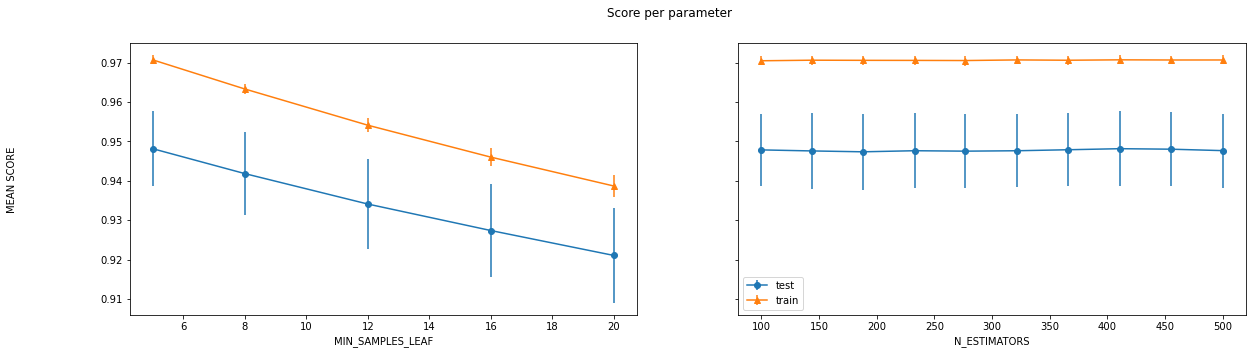

In [32]:
plot_search_results(rfr_Grid)

In [33]:
listOfClass = df_all.groupby('Super.Class')
listOfData = [listOfClass.get_group(x) for x in listOfClass.groups]

In [34]:
from sklearn.model_selection import GridSearchCV

def tuning (df):
    output = {}
    label = df.iloc[0]['Super.Class']
    ind_bit0 = df.columns.get_loc("Bit_0")
    ind_bit0
    X = df.iloc[:,ind_bit0:]
    y = df['CCS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
    
    output['Super_Class'] = label
    output['X_train_shape'] = np.shape(X_train)
    output['X_test_shape'] = np.shape(X_test)
    output['y_train_shape'] = np.shape(y_train) 
    output['y_test_shape'] = np.shape(y_test)
    output['X_train'] = X_train
    output['X_test'] = X_test
    output['y_train'] = y_train
    output['y_test'] = y_test
    
    param_grid_CCS = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split2,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
    
    rfr_Model = RandomForestRegressor(oob_score = [True])
    
    rfr_Grid = GridSearchCV(estimator = rfr_Model, 
                       param_grid = param_grid_CCS, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True)
    
    
    rfr_Grid.fit(X_train, y_train)
    
    output['Train_Accuracy'] = rfr_Grid.score(X_train,y_train)
    output['Test_Accuracy'] = rfr_Grid.score(X_test,y_test)
    output['Grid'] = rfr_Grid
    
    return output

In [35]:
summaryOfGridR = [tuning(i) for i in listOfData]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [36]:
for i in summaryOfGridR:
    label = i['Super_Class']
    train_accuray = i['Train_Accuracy']
    test_accuray = i['Test_Accuracy']
    best = i['Grid'].best_params_
    
    print(label)
    print(best)
    print (f'Train Accuracy - : { train_accuray:.3f}')
    print (f'Test Accuracy - : {test_accuray:.3f}')

Benzenoids
{'min_samples_leaf': 5, 'n_estimators': 144}
Train Accuracy - : 0.943
Test Accuracy - : 0.867
Lipids and lipid-like molecules
{'min_samples_leaf': 5, 'n_estimators': 100}
Train Accuracy - : 0.943
Test Accuracy - : 0.925
Organic acids and derivatives
{'min_samples_leaf': 5, 'n_estimators': 366}
Train Accuracy - : 0.962
Test Accuracy - : 0.771
Organic oxygen compounds
{'min_samples_leaf': 5, 'n_estimators': 455}
Train Accuracy - : 0.930
Test Accuracy - : 0.889
Organoheterocyclic compounds
{'min_samples_leaf': 5, 'n_estimators': 411}
Train Accuracy - : 0.962
Test Accuracy - : 0.910


In [64]:
filename = 'summary_ClassGridR.joblib'
joblib.dump(summaryOfGridR, filename)

['summary_ClassGridR.joblib']

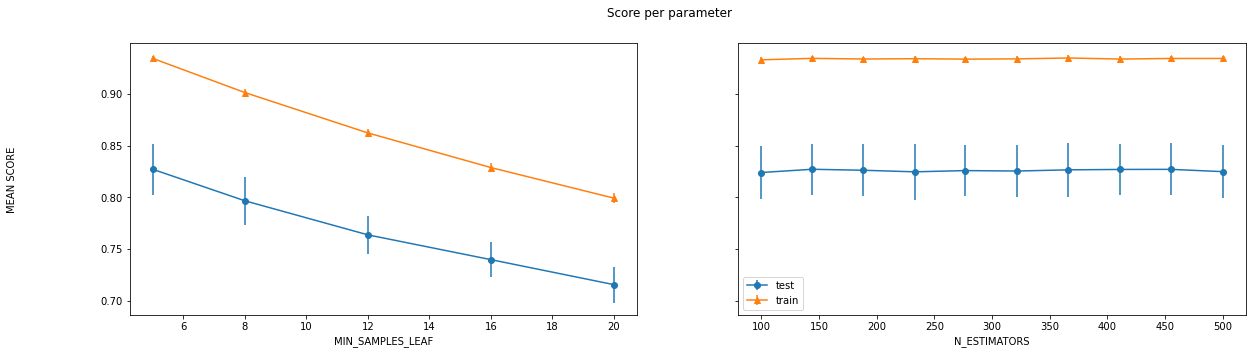

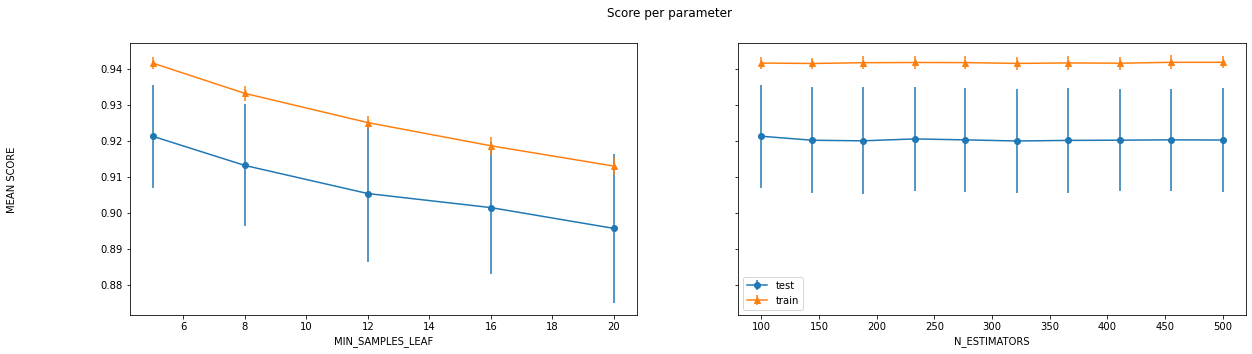

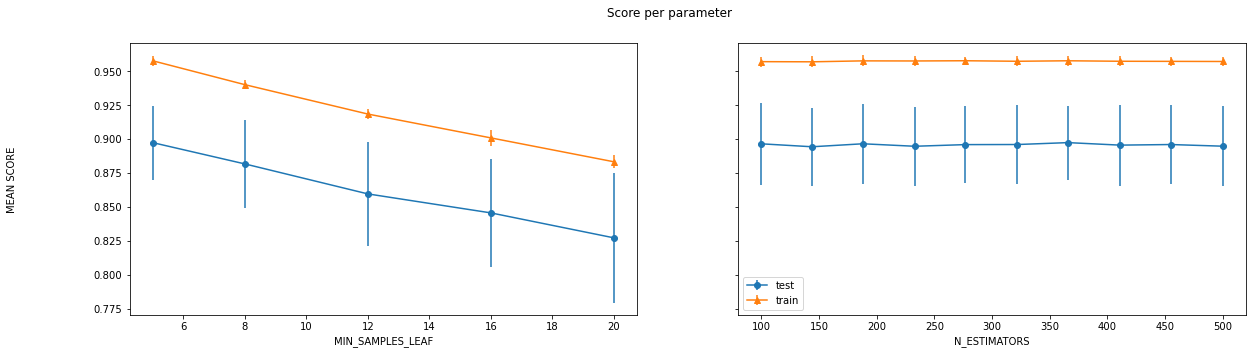

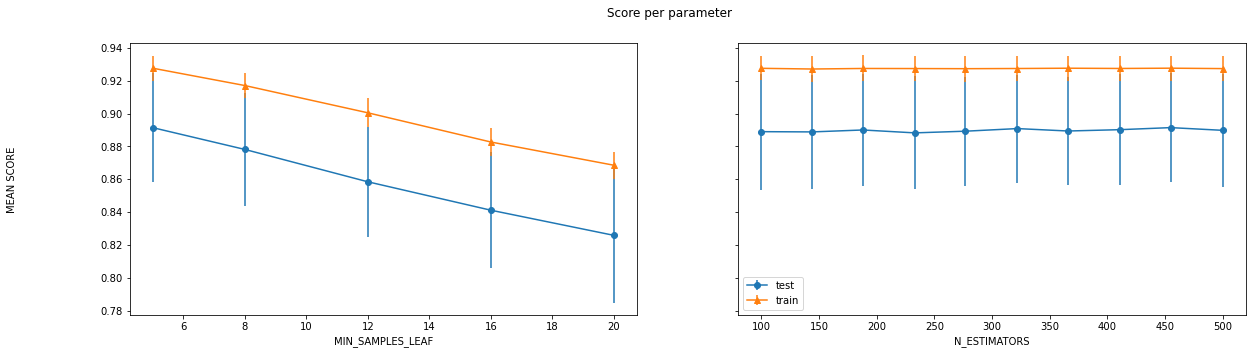

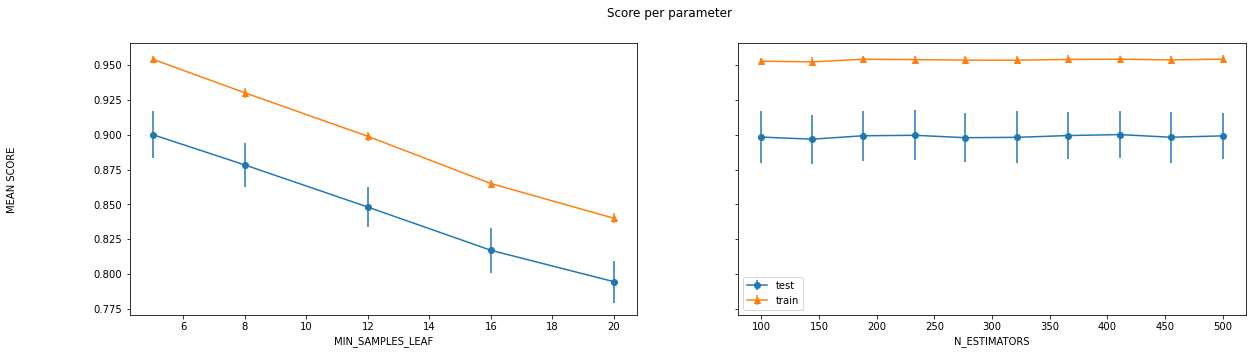

In [37]:
for i in summaryOfGridR:
    plot_search_results(i['Grid'])

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
C:\Users\fyang\Anaconda3

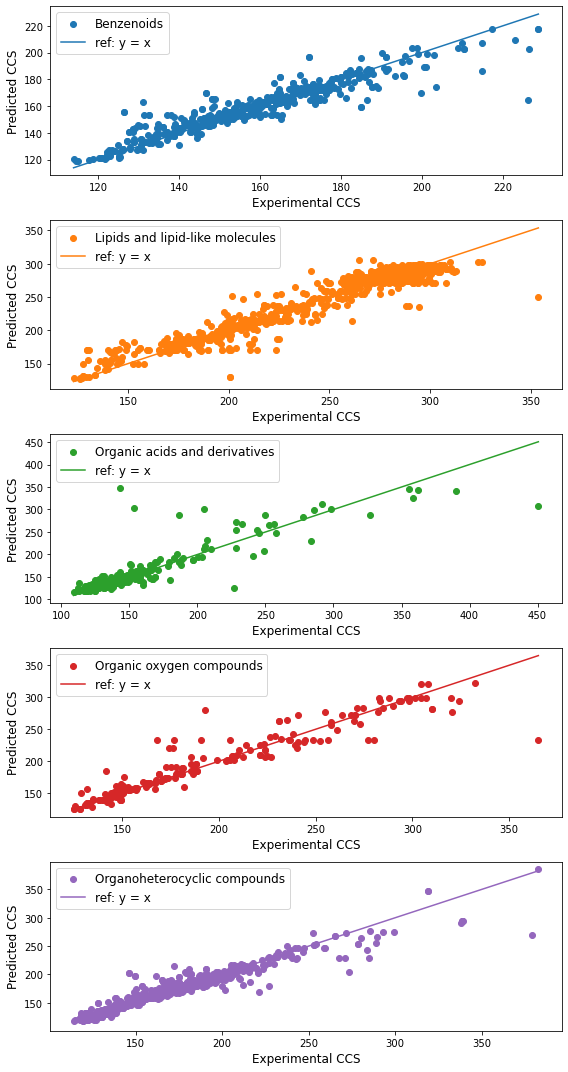

In [47]:
from scipy import stats
import matplotlib

fig, axs =plt.subplots(5,1,figsize = (8,15))



colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd']


for i, color in zip(range(5), colors):   
    grid = summaryOfGridR[i]['Grid']
    X_test = summaryOfGridR[i]['X_test']
    y_test = summaryOfGridR[i]['y_test']
    label = summaryOfGridR[i]['Super_Class']
    pred = grid.predict(X_test)
    summaryOfGridR[i]['prediction'] = pred
    
    lims = [
    np.min(min(y_test)),  # min of both axes
    np.max(max(y_test)),  # max of both axes
    ]
    
    axs[i].scatter(y_test, pred, c = color, label =label)
    axs[i].plot(lims, lims, 'k-', c = color, label = 'ref: y = x')
    
    axs[i].set_xlabel('Experimental CCS', fontsize = 12)
    axs[i].set_ylabel('Predicted CCS', fontsize = 12)
    
    # no classifier CCS prediction
    
for ax in axs:
    ax.legend(loc = 2, fontsize = 'large')
fig.tight_layout()
plt.show()
fig.savefig('full_figure.png')

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


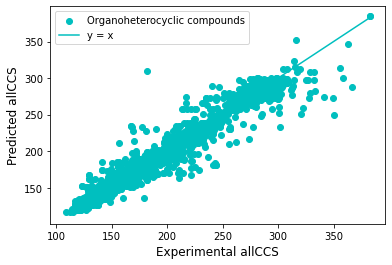

In [52]:
pred_all = rfr_Grid.predict(X_Re_test)
plt.scatter(y_Re_test, pred_all, c = 'c', label =label)
plt.plot(lims, lims, 'k-', c = 'c', label = 'y = x')
plt.xlabel('Experimental allCCS', fontsize = 12)
plt.ylabel('Predicted allCCS', fontsize = 12)
plt.legend()
plt.savefig('allCCS_test.png')

In [62]:
label = summaryOfGridR[4]['Super_Class']
grid = summaryOfGridR[4]['Grid']

In [63]:
filename = label + '_GridR.joblib'
joblib.dump(grid, filename)

['Organoheterocyclic compounds_GridR.joblib']